In [1]:
## ---- Partition Cell Set Network Module Plotting ---- 0682.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Develop and Implement a Comprehensive Network Plotting Strategy
## Plot Network Modules Using New Plotting Strategy

In [1]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [2]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [3]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)

## Get the igraph utilities
source('/gpfs/home/devans/code/Utilities/fromSara/setup_igraph.r')
source('/gpfs/home/devans/code/Utilities/fromSara/recursive_louvain.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_score.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_overlap.r')
source('/gpfs/home/devans/code/Utilities/fromSara/plot_by_cluster.r')

## Alternate to stat_parm utility in igraph utilities (does not assume log10 data)
stat_parm2 <- function(gf, expdata){
    
    ## Remove expression values not in the network, get antilog
    # expdata_filt <- 10 ^ log10expdata[,V(gf)$name]
    expdata_filt <- expdata[,V(gf)$name]
    
    ## Compute the node expression stats, including coeff of variation, add to network
    V(gf)$mean <- apply(expdata_filt, 2, mean)
    V(gf)$sd <- apply(expdata_filt, 2, sd)
    V(gf)$cv <- V(gf)$sd/V(gf)$mean
    V(gf)$med <- apply(expdata_filt, 2, median)

    ## Compute the strength
    V(gf)$strength <- strength(gf, weights = abs(E(gf)$pcor))
    return(gf)
    }
## Alternate to plot function in utility

plot_parm2 <- function (gf) {

    V(gf)$color <- 'red'
    
    E(gf)$color[E(gf)$pcor > 0] <- 'green'
    E(gf)$color[E(gf)$pcor < 0] <- 'orange'
    fedthick <- 100 * abs(E(gf)$pcor)
    V(gf)$label.cex = .1
    E(gf)$label.cex = .1
    V(gf)$label <- paste(substr(V(gf)$v27,1,10),
                                   round(V(gf)$strength,3), sep = '\n')
    E(gf)$width <- fedthick
    E(gf)$label <- round(E(gf)$pcor, 4)
    V(gf)$size <- 1

    return(gf)
    }

# Hex vertex shape, with a parameter for edges = 3 to get a hex
myhex <- function(coords, v=NULL, params) {
   vertex.color <- params("vertex", "color")
   if (length(vertex.color) != 1 && !is.null(v)) {
      vertex.color <- vertex.color[v]
   }  
    
   vertex.frame.color <- params("vertex", "frame.color")
   if (length(vertex.frame.color) != 1 && !is.null(v)) {
        vertex.frame.color <- vertex.frame.color[v]
   } 
    
   vertex.size  <- 1/200 * params("vertex", "size")
   if (length(vertex.size) != 1 && !is.null(v)) {
      vertex.size <- vertex.size[v]
   }
   norays <- params("vertex", "norays")
   if (length(norays) != 1 && !is.null(v)) {
      norays <- norays[v]
   }

   mapply(coords[,1], coords[,2], vertex.color, vertex.frame.color, vertex.size, norays,
          FUN=function(x, y, bg, fg, size, nor) {
             symbols(x=x, y=y, bg=bg, fg = fg,
                     stars=matrix(c(size,size), nrow=1, ncol=nor*2),
                     add=TRUE, inches=FALSE)
          })
}
# no clipping, edges will be below the vertices anyway
add_shape("hex", clip=shape_noclip,
          plot=myhex, parameters=list(vertex.norays=3))

In [6]:
## Read the previously preprocessed downsampled cell set data object
setwd(datdir)
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [7]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [37]:
get_case_parms <- function(case) {
    print(typeof(case))
    if (case == '002') print('match')
    
# VSMC Cases
# case 001, use vsmc_mod13_genes
# case 002, use vsmc_mod31_genes
# case 003, use vsmc_mod31plus2_genes
# case 004, use vsmc_mod11_genes
# case 005, use vsmc_mod30_genes
## EC Cases
# case 101, use ec_mod1_genes
# case 102, use ec_mod35_genes 
# case 103, use ec_mod36_genes
    
    # Special Genes Set 2:
    # ECs:
    ec_mod1_genes <- c('ITLN1', 'S100A4', 'SCX')
    ec_mod35_genes <- c('ESM1', 'PDGFD') 
    ec_mod36_genes <- c('IER2', 'FOS')
    ec_mod36p_genes <- c('IER2', 'FOS', 'NFKBIA')
    ## EC Gene IDs
    ec_mod1_geneids <- short2geneid[ec_mod1_genes]
    ec_mod35_geneids <- short2geneid[ec_mod36_genes]
    ec_mod36_geneids <- short2geneid[ec_mod35_genes]
    ec_mod36p_geneids <- short2geneid[ec_mod36p_genes]
    # VSMC:
    vsmc_mod9_genes <- c('TNFAIP2', 'NFKBIA', 'SFRP5', 'CRTAC1')
    vsmc_mod11_genes <- 'IGSF10'
    vsmc_mod13_genes <- c('SPP1', 'IBSP', 'POSTN')
    vsmc_mod30_genes <- c('TRA3', 'SEMA3C', 'C1QTNF3', 'NTM', 'FBN1')
    vsmc_mod31_genes <- c('ZFP36', 'EGR1', 'JUNB', 'FOSB', 'FOS', 'IER2')
    vsmc_mod31plus2_genes <- c(vsmc_mod31_genes, 'TNFAIP2', 'NFKBIA')
    vsmc_mod9.31_genes <- c(vsmc_mod9_genes, vsmc_mod31_genes)
    ## VSMC Gene IDs
    vsmc_mod13_geneids <- short2geneid[vsmc_mod9_genes]
    vsmc_mod11_geneids <- short2geneid[vsmc_mod11_genes]
    vsmc_mod13_geneids <- short2geneid[vsmc_mod13_genes]
    vsmc_mod30_geneids <- short2geneid[vsmc_mod30_genes]
    vsmc_mod31_geneids <- short2geneid[vsmc_mod31_genes]
    vsmc_mod9.31_geneids <- short2geneid[vsmc_mod9.31_genes]
    vsmc_mod31plus2_geneids <- short2geneid[vsmc_mod31plus2_genes]

    
    ## Default to NULL for return variables
    p <- NULL
    genes_oi <- NULL
    extend_con <- NULL
    plotfile <- NULL
    scs <- NULL
    
    ## Scan through cases and get correct return parameters
    if (case == '001') { 
        p <- 3
        genes_oi <- vsmc_mod13_genes
        extend_con <- 1
        plotfile <- paste('VSMC.Module13.Deg', extend_con, '.SpecialGeneSet2.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 13

    } else if (case == '002') {
        print('here2')
        p <- 3
        genes_oi <- vsmc_mod31_genes
        extend_con <- 2
        plotfile <- paste('VSMC.Module31.SpecialGeneSet2.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 31

    } else if (case == '003') {
        p <- 3
        genes_oi <- vsmc_mod31plus2_genes
        extend_con <- 1
        plotfile <- paste('VSMC.Module31Plus2.Deg',extend_con,'.SpecialGeneSet2.rev5.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- c(9, 31)

    } else if (case == '004') {
        p <- 3
        genes_oi <- vsmc_mod11_genes
        extend_con <- 2
        plotfile <- paste('VSMC.Module11.SpecialGeneSet2.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 11

    } else if (case == '005') {
        p <- 3
        genes_oi <- vsmc_mod30_genes
        extend_con <- 1
        plotfile <- paste('VSMC.Module30.SpecialGeneSet2.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 30

    } else if (case == '101') {
        p <- 2
        genes_oi <- ec_mod1_genes
        extend_con <- 1
        plotfile <- paste('EC.Module1.SpecialGeneSet2.rev4.pdf', sep = '')    
        scs <- c(1, 1, 7)
        mods <- 1

    } else if (case == '102') {
        p <- 2
        genes_oi <- ec_mod35_genes
        extend_con <- 2
        plotfile <- paste('EC.Module35.SpecialGeneSet2.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 35

    } else if (case == '103') {
        p <- 2
        genes_oi <- ec_mod36_genes
        extend_con <- 2
        plotfile <- paste('EC.Module36.SpecialGeneSet2.rev4.pdf', sep = '') 
        scs <- c(1, 1, 7)
        mods <- 36
        
    } else if (case == '104') {
        p <- 2
        genes_oi <- ec_mod36p_genes
        extend_con <- 2
        plotfile <- paste('EC.Module36p.SpecialGeneSet2.rev4.pdf', sep = '') 
        scs <- c(1, 1, 7)
        mods <- c(16, 36)
            
    } else if (case == '201') {
        p <- 3
        genes_oi <- ''
        extend_con <- NA
        plotfile <- paste('VSMC.Module9.DE.rev4.pdf', sep = '')
        scs <- c(1, 1, 7)
        mods <- 9
    
    } else print("Error, not a valid case")
    return(list(p, genes_oi, extend_con, plotfile, scs, mods))
}

[1] "character"
[[1]]
[1] 2

[[2]]
[1] "ITLN1"  "S100A4" "SCX"   

[[3]]
[1] 1

[[4]]
[1] "EC.Module1.SpecialGeneSet2.rev4.pdf"

[[5]]
[1] 1 1 7

[[6]]
[1] 1

[1] 1
NULL
[1] "plot file names is:  EC.Module1.SpecialGeneSet2.rev4.pdf"


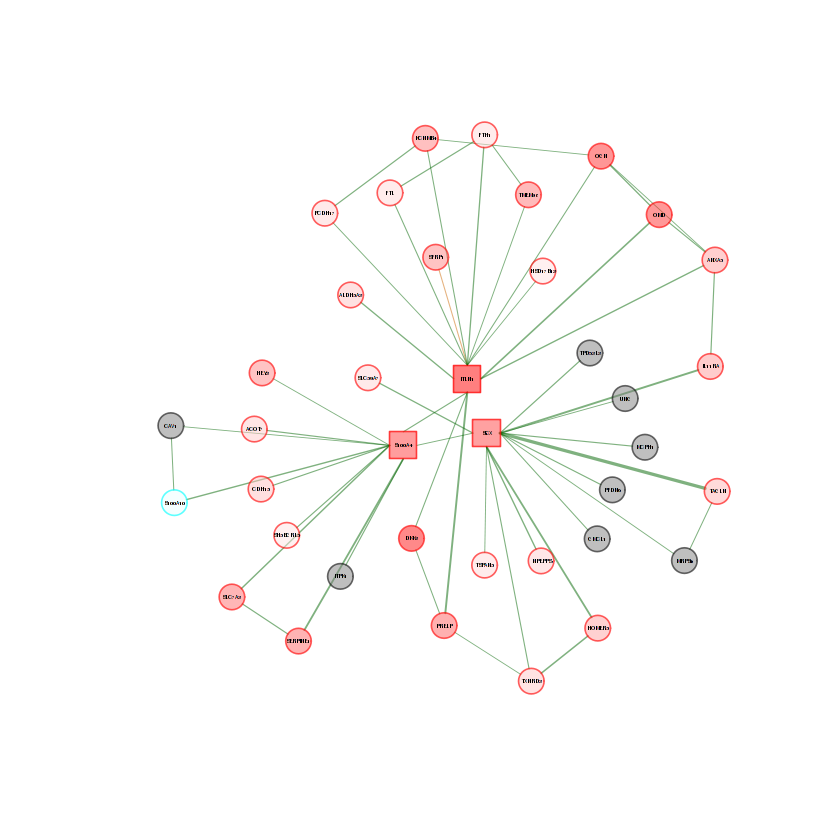

In [42]:

for (cases in c('101')) {
    caseinfo <- get_case_parms(cases)
    print(caseinfo)
    p <- unlist(caseinfo[1])
    genes_oi <- unlist(caseinfo[2])
    extend_con <- unlist(caseinfo[3])
    plotfile <- unlist(caseinfo[4])
    scs <- unlist(caseinfo[5])
    scale <- scs[1]
    nodescale <- scs[2]
    mods <- unlist(caseinfo[6])
    print(mods)

    ## Other control parameter(s)
    diff_exp_qval_cut <- 0.05

    ## Set up directory path and files as needed
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
   
    ## Read partition cell data set, expression data, and diff expression data
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    partn_exp <- t(exprs(partn_cds))
    de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)    

    ## Read everything related to partition network    
    net2 <- readRDS('Network.20k.rds')
    net2_clust <- readRDS('Louvain.Clust.20k.rds')
    clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')

    ## Remove DE genes that are duplicates and add vertex attribute with the DE q values
    net_genes <- V(net2)$v27
    dups <- duplicated(de_tab$gene_short_name)
    de_tab_dups <- de_tab$gene_short_name[dups]
    dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
    idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
    j <- 1
    for (i in 1:length(de_tab_dups)) {
        if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
        else idx_2_rmv[i] <- dup_idxs[j]
        j <- j + 2
    }
    de_tab_rmdups <- de_tab[-idx_2_rmv,]
    rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
    V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
    V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
    de_tab <- de_tab_rmdups


    ## Get the significant differential expressed terms
    qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
        dplyr::select(gene_short_name, normalized_effect, q_value)

    ## Recolor significant DE genes, inverting red and green from what's in net2
    V(net2)$color <- rgb(.5, .5, .5, alpha = .5)  # Gray
    gene2ne <- qsig$normalized_effect
    names(gene2ne) <- qsig$gene_short_name
    gene2ne <- gene2ne/max(abs(gene2ne))
    gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
    gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

    V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <-                     # Cyan
        rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 1, alpha = .5) 
    V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <-                     # Red
        rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
            gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

    ## Populate the partition nodes (genes) with their Diff Exp Status
    ## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
    rownames(qsig) <- short2geneid[qsig[,1]]
    V(net2)$diffexp <- 0
    genes <- V(net2)$name
    for (gene in 1:length(genes)) {
        de <- qsig[genes[gene],]
    if (!is.na(de[1])) {
        V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
        }
    
    }

    gm1 <- induced_subgraph(net2, V(net2)$name[which(membership(net2_clust) %in% mods)] )
    ## Fix the network for case 104 (remove most of EC module 16)
    if (cases == 104) {
        vmod16 <- V(net2)$name[which(membership(net2_clust) %in% 16)]
        vmod16x <- vmod16
        # length(vmod16)
        nfkbib_w <- which(vmod16 %in% short2geneid['NFKBIA'])
        vmod16x <- vmod16x[-nfkbib_w]
        # length(vmod16x)
        gm1 <- delete_vertices(gm1, v = vmod16x)
    }

    ## This code filters the modules to genes of interest and nearby genes
    adj_verts <- adjacent_vertices(gm1, v = short2geneid[genes_oi])
    adj_verts <- V(gm1)$name[unique(unlist(adj_verts))]
    sub_verts2 <- unique(union(short2geneid[genes_oi], adj_verts))
    gm2 <-  induced_subgraph(gm1, v = sub_verts2)

    ## For selected set of genes, expand network to second degree of nodes
    if (extend_con == 2) {
        adj_verts <- adjacent_vertices(gm1, v = sub_verts2)
        adj_verts <- V(gm1)$name[unique(unlist(adj_verts))]
        sub_verts2 <- unique(union(sub_verts2, adj_verts))
        gm2 <-  induced_subgraph(gm1, v = sub_verts2)
    }

    ## This is where the network plotting parameters are coded into the network
    g <- gm2
    set.seed(101)
    layout <- layout_with_gem(g) * .5
    V(g)$size <- 15 * 3 / 5 * nodescale
    # V(g)$color <- 'skyblue2'
    V(g)$frame.color <- '#FFFF0080'  # 'black'
    V(g)$shape <- 'circle'
    V(g)$label <- V(g)$v27 ## Overwrite what is stored in the network, which includes the strength
    # V(g)$label.family <- 'helvetica'
    V(g)$label.font <- 1
    V(g)$label.cex <- 1. * .22 * scale * nodescale
    V(g)$label.color <- 'black'
    # E(g)$color <- 'darkgray'
    E(g)$width <- 1 * scale * nodescale
    E(g)$lty <- 1
    E(g)$label <- NA
    # E(g)$label.family <- 'helvetica'
    E(g)$label.font <- 1
    E(g)$label.cex <- 1
    E(g)$label.color <- 'skyblue2'
    E(g)$curved <- FALSE
    specialnodes <<- which(V(g)$v27 %in% genes_oi)
    V(g)$shape[specialnodes] <- 'csquare'
    V(g)$size[specialnodes] <- V(g)$size[specialnodes] * 1.1
    V(g)$frame.color[V(g)$diffexp == -1] <- '#FF0000A0'
    V(g)$frame.color[V(g)$diffexp == 0]  <- '#101010A0'
    V(g)$frame.color[V(g)$diffexp == 1]  <- '#00FFFFA0'
    E(g)$color[E(g)$pcor >= 0] <- '#00640080'
    E(g)$color[E(g)$pcor < 0]  <- '#CC660080'
    E(g)$width = 20 * abs(E(g)$pcor)
    
    print(plot(g, layout = layout, edge.label.family = "Helvetica", vertex.label.family = "Helvetica"))
    print(paste('plot file names is: ', plotfile), sep = '')
    pdf(plotfile, width = scs[3], height = scs[3])
       plot(g, layout = layout, edge.label.family = "Helvetica", vertex.label.family = "Helvetica")
    dev.off()
}

In [51]:
gm1
gm1x

IGRAPH 24c18c5 UNW- 533 776 -- 
+ attr: name (v/c), v27 (v/c), v27type (v/c), strength (v/n), degree
| (v/n), mean (v/n), sd (v/n), cv (v/n), med (v/n), gene (v/c), sdesc
| (v/c), ename (v/c), biotype (v/c), chr (v/c), strtpos (v/n), endpos
| (v/n), color (v/c), label.cex (v/n), label (v/c), size (v/n), de_qval
| (v/n), diffexp (v/n), pcor (e/n), pval (e/n), qval (e/n), lfdr (e/n),
| ord (e/n), row (e/n), col (e/n), idx (e/n), arank (e/n), weight
| (e/n), color (e/c), label.cex (e/n), width (e/n), label (e/n)
+ edges from 24c18c5 (vertex names):
[1] ENSG00000176261--ENSG00000134686 ENSG00000134686--ENSG00000085832
[3] ENSG00000117228--ENSG00000162645 ENSG00000117228--ENSG00000162654
+ ... omitted several edges

IGRAPH 0daa3b3 UNW- 64 97 -- 
+ attr: name (v/c), v27 (v/c), v27type (v/c), strength (v/n), degree
| (v/n), mean (v/n), sd (v/n), cv (v/n), med (v/n), gene (v/c), sdesc
| (v/c), ename (v/c), biotype (v/c), chr (v/c), strtpos (v/n), endpos
| (v/n), color (v/c), label.cex (v/n), label (v/c), size (v/n), de_qval
| (v/n), diffexp (v/n), pcor (e/n), pval (e/n), qval (e/n), lfdr (e/n),
| ord (e/n), row (e/n), col (e/n), idx (e/n), arank (e/n), weight
| (e/n), color (e/c), label.cex (e/n), width (e/n), label (e/n)
+ edges from 0daa3b3 (vertex names):
[1] ENSG00000180488--ENSG00000143924 ENSG00000117036--ENSG00000132842
[3] ENSG00000143384--ENSG00000120738 ENSG00000177606--ENSG00000120129
+ ... omitted several edges

In [165]:
# Special Case, Combining Genes in Module 36 with a Gene in Module 16
ec_mod36.p_genes <- c('IER2', 'FOS', 'NFKBIA')
ec_mod36p_geneids <- short2geneid[ec_mod36p_genes]

p <- 2
genes_oi <- ec_mod36p_genes
extend_con <- 2
plotfile <- paste('EC.Module36p.SpecialGeneSet2.rev4.pdf', sep = '') 
scs <- c(1, 1, 7)
# mods <- 36

## Other control parameter(s)
diff_exp_qval_cut <- 0.05

## Set up directory path and files as needed
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
   
## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
partn_exp <- t(exprs(partn_cds))
de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)    

## Read everything related to partition network    
net2 <- readRDS('Network.20k.rds')
net2_clust <- readRDS('Louvain.Clust.20k.rds')
clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')

## Remove DE genes that are duplicates and add vertex attribute with the DE q values
net_genes <- V(net2)$v27
dups <- duplicated(de_tab$gene_short_name)
de_tab_dups <- de_tab$gene_short_name[dups]
dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
j <- 1
for (i in 1:length(de_tab_dups)) {
    if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
    else idx_2_rmv[i] <- dup_idxs[j]
    j <- j + 2
    }
de_tab_rmdups <- de_tab[-idx_2_rmv,]
rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
de_tab <- de_tab_rmdups


## Get the significant differential expressed terms
qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
    dplyr::select(gene_short_name, normalized_effect, q_value)

## Recolor significant DE genes, inverting red and green from what's in net2
V(net2)$color <- rgb(.5, .5, .5, alpha = .5)  # Gray
gene2ne <- qsig$normalized_effect
names(gene2ne) <- qsig$gene_short_name
gene2ne <- gene2ne/max(abs(gene2ne))
gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <-                     # Cyan
    rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 1, alpha = .5) 
V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <-                     # Red
    rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
        gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

    ## Populate the partition nodes (genes) with their Diff Exp Status
    ## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
    rownames(qsig) <- short2geneid[qsig[,1]]
    V(net2)$diffexp <- 0
    genes <- V(net2)$name
    for (gene in 1:length(genes)) {
        de <- qsig[genes[gene],]
    if (!is.na(de[1])) {
        V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
        }
    
    }

    gm1 <- induced_subgraph(net2, V(net2)$name[which(membership(net2_clust) %in% mods)] )
    # table(membership(net2_clust))

    ## This code filters the modules to genes of interest and nearby genes
    adj_verts <- adjacent_vertices(gm1, v = short2geneid[genes_oi])
    adj_verts <- V(gm1)$name[unique(unlist(adj_verts))]
    sub_verts2 <- unique(union(short2geneid[genes_oi], adj_verts))
    gm2 <-  induced_subgraph(gm1, v = sub_verts2)

    ## For selected set of genes, expand network to second degree of nodes
    if (extend_con == 2) {
        adj_verts <- adjacent_vertices(gm1, v = sub_verts2)
        adj_verts <- V(gm1)$name[unique(unlist(adj_verts))]
        sub_verts2 <- unique(union(sub_verts2, adj_verts))
        gm2 <-  induced_subgraph(gm1, v = sub_verts2)
    }

    ## This is where the network plotting parameters are coded into the network
    g <- gm2
    set.seed(101)
    layout <- layout_with_gem(g) * .5
    V(g)$size <- 15 * 3 / 5 * nodescale
    # V(g)$color <- 'skyblue2'
    V(g)$frame.color <- '#FFFF0080'  # 'black'
    V(g)$shape <- 'circle'
    V(g)$label <- V(g)$v27 ## Overwrite what is stored in the network, which includes the strength
    # V(g)$label.family <- 'helvetica'
    V(g)$label.font <- 1
    V(g)$label.cex <- 1. * .22 * scale * nodescale
    V(g)$label.color <- 'black'
    # E(g)$color <- 'darkgray'
    E(g)$width <- 1 * scale * nodescale
    E(g)$lty <- 1
    E(g)$label <- NA
    # E(g)$label.family <- 'helvetica'
    E(g)$label.font <- 1
    E(g)$label.cex <- 1
    E(g)$label.color <- 'skyblue2'
    E(g)$curved <- FALSE
    specialnodes <<- which(V(g)$v27 %in% genes_oi)
    V(g)$shape[specialnodes] <- 'csquare'
    V(g)$size[specialnodes] <- V(g)$size[specialnodes] * 1.1
    V(g)$frame.color[V(g)$diffexp == -1] <- '#FF0000A0'
    V(g)$frame.color[V(g)$diffexp == 0]  <- '#101010A0'
    V(g)$frame.color[V(g)$diffexp == 1]  <- '#00FFFFA0'
    E(g)$color[E(g)$pcor >= 0] <- '#00640080'
    E(g)$color[E(g)$pcor < 0]  <- '#CC660080'
    E(g)$width = 20 * abs(E(g)$pcor)
    
    plot(g, layout = layout, edge.label.family = "Helvetica", vertex.label.family = "Helvetica")
    print(paste('plot file names is: ', plotfile), sep = '')
    pdf(plotfile, width = scs[3], height = scs[3])
       plot(g, layout = layout, edge.label.family = "Helvetica", vertex.label.family = "Helvetica")
    dev.off()




In [21]:

    ec_mod36p_genes <- c('IER2', 'FOS', 'NFKBIA')
    ec_mod36p_geneids <- short2geneid[ec_mod36p_genes]

In [25]:
ec_mod36p_geneids

IER2               FOS            NFKBIA 
"ENSG00000160888" "ENSG00000170345" "ENSG00000100906"

In [28]:
   V(gm1)$v27

[1] "JUN"       "MIGA1"     "MCL1"      "ETV3"      "RGS16"     "ATF3"     
 [7] "RHOB"      "NDUFAF7"   "EML4"      "IMMT"      "ADAMTS9"   "AP3B1"    
[13] "EGR1"      "DUSP1"     "HSPA1A"    "HSPA1B"    "CDKN1A"    "PPIL1"    
[19] "POLR1C"    "HSPB1"     "ZKSCAN1"   "STC1"      "TMEM55A"   "POLR2K"   
[25] "NFX1"      "STOML2"    "C9orf3"    "KLF4"      "GAPVD1"    "B4GAT1"   
[31] "CHKA"      "TMEM25"    "KLF6"      "ANXA11"    "XPNPEP1"   "EMP1"     
[37] "TSPAN31"   "DUSP6"     "FOS"       "C14orf159" "DYNC1H1"   "HSP90AA1" 
[43] "FAM98B"    "USP8"      "ARPIN"     "ZNF720"    "THBD"      "CIRBP"    
[49] "GADD45B"   "JUNB"      "IER2"      "DNAJB1"    "KLF2"      "JUND"     
[55] "UPF1"      "BORCS8"    "ZFP36"     "SERTAD1"   "FOSB"      "NOVA2"    
[61] "IRF3"      "ZNF524"    "DGCR6L"